In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
url = "https://raw.githubusercontent.com/jeiloh/SDS384-Project/main/data/merged_df.csv"

# use pandas read_csv function to import the CSV file
merged_df = pd.read_csv(url)

# print the first few rows of the DataFrame
print(merged_df.head())

   Unnamed: 0  Census Tract Start  Day of Week  Hour  num_trips      TractId  \
0           0         48021950300            1    10          1  48021950300   
1           1         48021950300            1    17          1  48021950300   
2           2         48021950300            2    14          1  48021950300   
3           3         48021950300            3    18          1  48021950300   
4           4         48021950300            5    11          1  48021950300   

   State          County  TotalPop   Men  ...  Walk  OtherTransp  WorkAtHome  \
0  Texas  Bastrop County     15255  7591  ...   0.7          1.4         5.8   
1  Texas  Bastrop County     15255  7591  ...   0.7          1.4         5.8   
2  Texas  Bastrop County     15255  7591  ...   0.7          1.4         5.8   
3  Texas  Bastrop County     15255  7591  ...   0.7          1.4         5.8   
4  Texas  Bastrop County     15255  7591  ...   0.7          1.4         5.8   

   MeanCommute  Employed  PrivateWork 

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt  
import matplotlib

from scipy import stats
import xgboost

import seaborn as sns

In [4]:
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import roc_curve, auc, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression

In [5]:
from sklearn.inspection import partial_dependence
from sklearn.inspection import PartialDependenceDisplay

In [6]:
merged_df = merged_df.dropna()

In [7]:
merged_df.shape

(14565, 42)

In [8]:
features = ['Census Tract Start', 'Day of Week','Hour','TotalPop', 'Hispanic', 'White', 'Black',
       'Native', 'Asian', 'Pacific', 'VotingAgeCitizen', 'Income', 'IncomeErr',
       'IncomePerCap', 'IncomePerCapErr', 'Poverty', 'ChildPoverty',
       'Professional', 'Service', 'Office', 'Construction', 'Production',
       'Drive', 'Carpool', 'Transit', 'Walk', 'OtherTransp', 'WorkAtHome',
       'MeanCommute', 'Employed', 'PrivateWork', 'PublicWork', 'SelfEmployed',
       'FamilyWork', 'Unemployment']
dependent_var = ['num_trips']

In [9]:
merged_df['Census Tract Start'] = merged_df['Census Tract Start'].astype(int)

In [10]:
X = merged_df[features]
y = merged_df[dependent_var]

In [11]:
y = np.array(y)

In [12]:
max_depth_array = [2, 3, 4, 5, 6, 7, 8, 9, 10]

mse_mean = []
mse_std = []

# Split the dataset into training and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y.ravel(), test_size=0.15, random_state=42)

for max_depth in max_depth_array:
    rf_mse = []
    
    # Perform 10-fold cross-validation on the training set
    kf = KFold(n_splits=5, random_state=42, shuffle=True)
    for train_index, val_index in kf.split(X_train_val):
        X_train, X_val = X_train_val.iloc[train_index], X_train_val.iloc[val_index]
        y_train, y_val = y_train_val[train_index], y_train_val[val_index]

        model = RandomForestRegressor(max_depth=max_depth).fit(X_train, y_train)
        y_pred = model.predict(X_val)
        mse = mean_squared_error(y_val, y_pred)
        rf_mse += [mse]

    print("max_depth %i -- MSE : %0.3f +- %0.3f"%(max_depth, np.mean(rf_mse), np.std(rf_mse)))
    mse_mean += [np.mean(rf_mse)]
    mse_std += [np.std(rf_mse)]

max_depth 2 -- MSE : 799792.574 +- 80597.159
max_depth 3 -- MSE : 456913.222 +- 37164.684
max_depth 4 -- MSE : 334008.023 +- 39685.175
max_depth 5 -- MSE : 231204.452 +- 34240.769
max_depth 6 -- MSE : 154445.830 +- 26229.968
max_depth 7 -- MSE : 115001.364 +- 20040.457
max_depth 8 -- MSE : 90873.177 +- 20530.561
max_depth 9 -- MSE : 77783.278 +- 14003.839
max_depth 10 -- MSE : 68518.292 +- 11808.126


In [13]:
max_depth_array = [2, 3, 4, 5, 6, 7, 8, 9, 10]

mse_xg_mean = []
mse_xg_std = []

# Split the dataset into training and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y.ravel(), test_size=0.15, random_state=42)

for max_depth in max_depth_array:
    mse_xg = []
    
    # Perform 10-fold cross-validation on the training set
    kf = KFold(n_splits=5, random_state=42, shuffle=True)
    for train_index, val_index in kf.split(X_train_val):
        X_train, X_val = X_train_val.iloc[train_index], X_train_val.iloc[val_index]
        y_train, y_val = y_train_val[train_index], y_train_val[val_index]

        model = xgboost.XGBRegressor(max_depth=max_depth).fit(X_train, y_train)
        y_pred = model.predict(X_val)
        mse_xg += [mean_squared_error(y_val, y_pred)]

    print("max_depth %i -- MSE : %0.3f +- %0.3f"%(max_depth, np.mean(mse_xg), np.std(mse_xg)))
    mse_xg_mean += [np.mean(mse_xg)]
    mse_xg_std += [np.std(mse_xg)]

max_depth 2 -- MSE : 322203.609 +- 60068.882
max_depth 3 -- MSE : 152951.079 +- 23645.392
max_depth 4 -- MSE : 69303.165 +- 9098.787
max_depth 5 -- MSE : 44384.629 +- 9146.213
max_depth 6 -- MSE : 35139.126 +- 9499.181
max_depth 7 -- MSE : 35957.743 +- 9587.975
max_depth 8 -- MSE : 36540.588 +- 7900.888
max_depth 9 -- MSE : 36749.184 +- 5911.703
max_depth 10 -- MSE : 38418.198 +- 7947.756


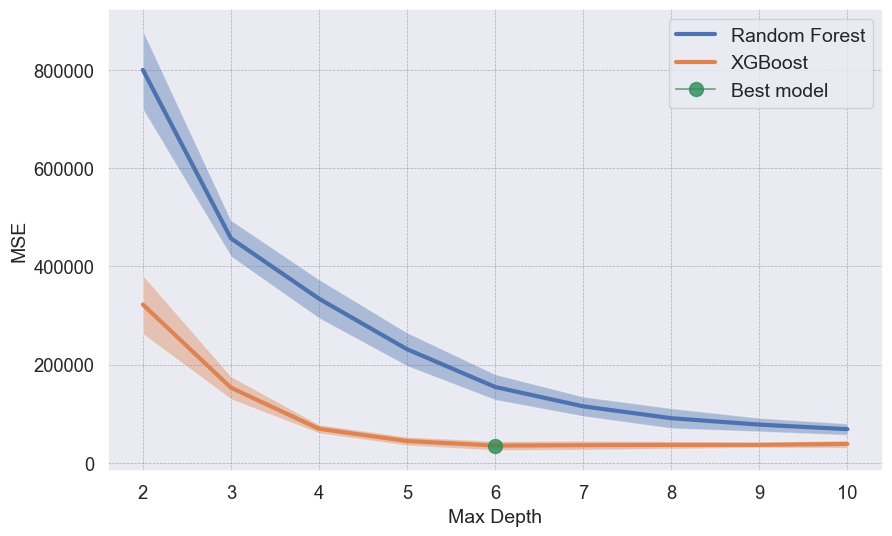

In [14]:
sns.set(font_scale=1.2)
sns.set_style("darkgrid")
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(max_depth_array, mse_mean, lw=3.0, label='Random Forest')
ax.fill_between(max_depth_array, np.array(mse_mean)+mse_std,  np.array(mse_mean)-mse_std, alpha=0.4)

ax.plot(max_depth_array, mse_xg_mean, lw=3.0, label='XGBoost')
ax.fill_between(max_depth_array, np.array(mse_xg_mean)+mse_xg_std,  np.array(mse_xg_mean)-mse_xg_std, alpha=0.4)
ax.plot(max_depth_array[np.argmin(mse_xg_mean)], np.min(mse_xg_mean), marker="o", markersize=10, markeredgecolor="seagreen", markerfacecolor="seagreen", alpha = 0.8, label = 'Best model')

ax.legend(loc='best', prop={'size':14})
ax.set_ylabel('MSE', size=14)
ax.set_xlabel('Max Depth', size=14)
ax.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.6)


In [15]:

# Train the final model with the optimal max_depth on the entire training set
optimal_max_depth = max_depth_array[np.argmin(mse_xg_mean)]
final_model = xgboost.XGBRegressor(max_depth=optimal_max_depth).fit(X_train_val, y_train_val)

# Evaluate the final model on the test set
y_pred_test = final_model.predict(X_test)
test_mse = mean_squared_error(y_test, y_pred_test)
print(f"Final model (max_depth={optimal_max_depth}) test MSE: {test_mse:.3f}")

Final model (max_depth=6) test MSE: 18722.519


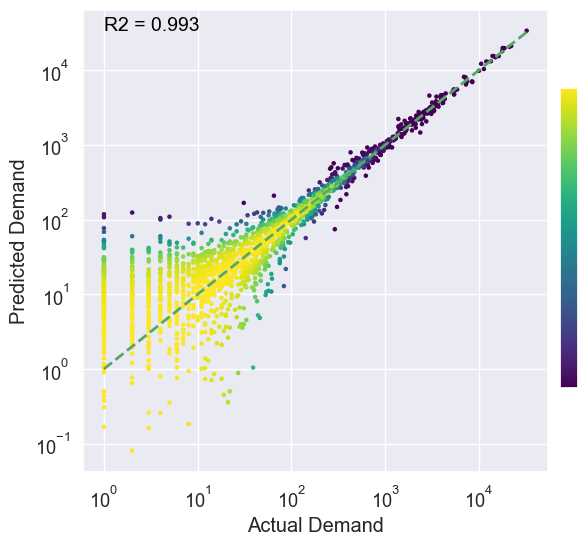

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score
from scipy.stats import gaussian_kde
from matplotlib.colorbar import ColorbarBase

# Make predictions on the test set
y_pred_test = final_model.predict(X_test)

# Calculate the R2 score
r2 = r2_score(y_test, y_pred_test)

# Estimate point density using Gaussian KDE
xy = np.vstack([y_test, y_pred_test])
z = gaussian_kde(xy)(xy)

# Create the colormap
cmap = plt.cm.get_cmap('viridis')

# Create the scatter plot with the density-based color
sns.set(font_scale=1.2)
fig, ax = plt.subplots(figsize=(6, 6))
sc = ax.scatter(y_test, y_pred_test, c=z, cmap=cmap, edgecolor=None, s=5)

cax = fig.add_axes([0.92, 0.25, 0.03, 0.5])
cb = ColorbarBase(cax, cmap=cmap, ticks=[])

# Set both axes to log scale
ax.set_xscale('log')
ax.set_yscale('log')

# Add a regression line with a confidence interval
#sns.regplot(x=y_test, y=y_pred_test, scatter=False, ax=ax, ci=95, line_kws={'color': 'red', 'linewidth': 2, 'label': 'Regression Line'}, logx=True)

# Add the x=y line for comparison
x_y_line = np.logspace(np.log10(np.min(y_test)), np.log10(np.max(y_test)), 100)
ax.plot(x_y_line, x_y_line, 'g--', linewidth=2, label='')

# Annotate the plot with the R2 score
ax.text(np.min(y_test), np.max(y_pred_test), f'R2 = {r2:.3f}', fontsize=14, color='black')

# Add title, labels
#ax.set_title("R2 Plot with Color Density, Regression Line, and x=y Line for XGBoost Model", fontsize=16, pad=20)
ax.set_xlabel("Actual Demand")
ax.set_ylabel("Predicted Demand")

# Add the legend
#ax.legend(loc='best')

# Show the plot
plt.show()


In [17]:
y_pred_final = final_model.predict(X)

In [18]:
demand = pd.concat([merged_df, pd.DataFrame(y_pred_final, columns=['prediction'])], axis=1)

In [19]:
selected_census_tracts = [48453001100, 48453000601, 48453000700]  # Add the Census Tract Start values to compare
filtered_data = demand[demand['Census Tract Start'].isin(selected_census_tracts)]

/var/folders/ph/078mk6ks7sbdb8385zl9m9s80000gn/T/ipykernel_15968/1349236439.py:8: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.lineplot(data=filtered_data, x='Hour', y='num_trips', hue='Census Tract Start', palette=palette, linestyle=':', linewidth=4, alpha=0.9, legend=False)
/var/folders/ph/078mk6ks7sbdb8385zl9m9s80000gn/T/ipykernel_15968/1349236439.py:9: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.lineplot(data=filtered_data, x='Hour', y='prediction', hue='Census Tract Start', palette=palette, linewidth=2, alpha=0.9, marker='o', dashes=False, legend='brief')


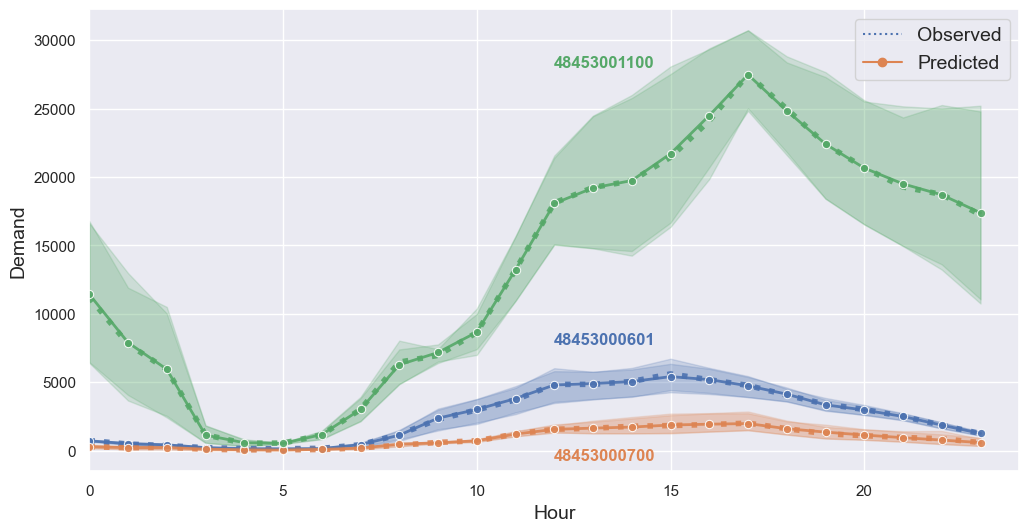

In [20]:
from matplotlib.lines import Line2D
palette = sns.color_palette()
observed_line = Line2D([], [], color=palette[0], label='Observed', linestyle=':')
predicted_line = Line2D([], [], color=palette[1], label='Predicted', marker='o')

sns.set(style="darkgrid")
plt.figure(figsize=(12, 6))
sns.lineplot(data=filtered_data, x='Hour', y='num_trips', hue='Census Tract Start', palette=palette, linestyle=':', linewidth=4, alpha=0.9, legend=False)
sns.lineplot(data=filtered_data, x='Hour', y='prediction', hue='Census Tract Start', palette=palette, linewidth=2, alpha=0.9, marker='o', dashes=False, legend='brief')

plt.xlabel('Hour', fontsize=14)
plt.ylabel('Demand', fontsize=14)
plt.xlim([0,24])
#plt.title('Demand by Hour for Selected Census Tract Starts', fontsize=16)
plt.legend(handles=[observed_line, predicted_line], fontsize=14)

plt.text(0.5, 0.9, "48453001100", transform=plt.gca().transAxes, fontsize=12, fontweight='bold', color = palette[2], va='top')
plt.text(0.5, 0.3, "48453000601", transform=plt.gca().transAxes, fontsize=12, fontweight='bold', color = palette[0], va='top')
plt.text(0.5, 0.05, "48453000700", transform=plt.gca().transAxes, fontsize=12, fontweight='bold', color = palette[1], va='top')
plt.show()

In [21]:
model = xgboost.XGBRegressor(max_depth=optimal_max_depth).fit(X, y)

In [22]:
# from xgboost import plot_importance
# plot_importance(model)

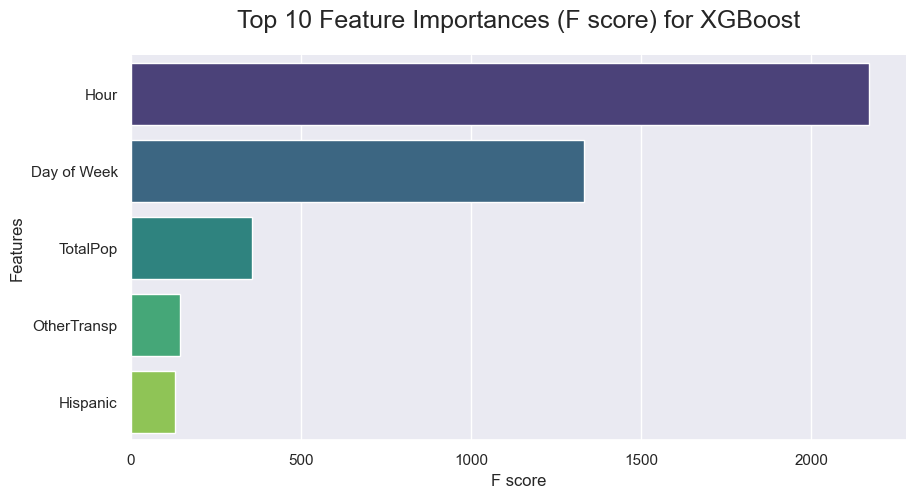

In [23]:
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns

# Assume your final model is named final_model

# Retrieve the feature importances from the model
fscores = final_model.get_booster().get_score(importance_type='weight')

# Get the feature names, replace this with your actual feature names
# feature_names = ['Feature 1', 'Feature 2', 'Feature 3', 'Feature 4', 'Feature 5']

# Sort the features and their importances in descending order
sorted_fscores = dict(sorted(fscores.items(), key=lambda item: item[1], reverse=True))

# Set the number of features to display
num_features = 5

# Prepare the data for plotting
features = list(sorted_fscores.keys())[:num_features]
scores = list(sorted_fscores.values())[:num_features]

# Plot the feature importances in a bar chart
fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(x=scores, y=features, palette='viridis', ax=ax)

# Set title, labels, and other visual enhancements
ax.set_title("Top 10 Feature Importances (F score) for XGBoost", fontsize=18, pad=20)
ax.set_xlabel("F score")
ax.set_ylabel("Features")
sns.despine()

# Show the plot
plt.show()


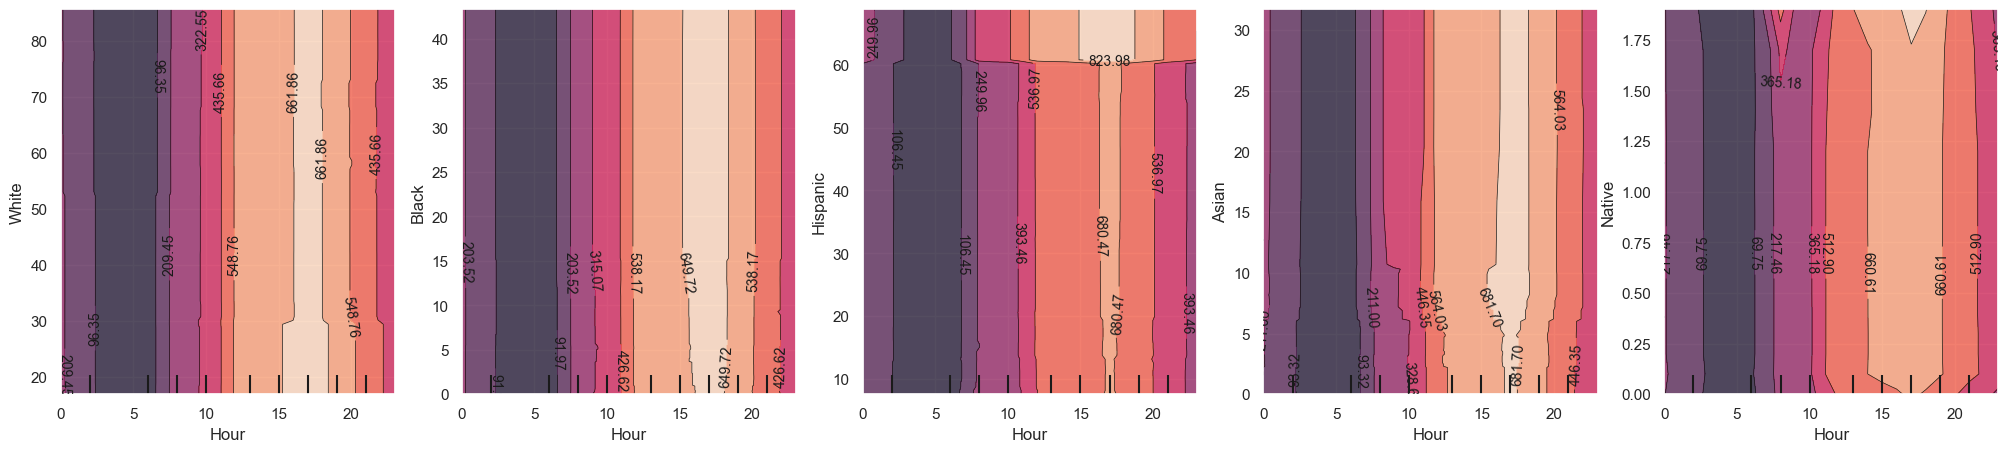

In [24]:
fig, ax = plt.subplots(1, 5, figsize=(25, 5))
features_PDP_2D = [('Hour', 'White')]
PartialDependenceDisplay.from_estimator(model, X, features_PDP_2D, ax=ax[0], kind='average')
ax[0].set_ylabel('Hispanic Ratio', size=14)
ax[0].set_xlabel('Hour (h)', size=14)
ax[0].grid()

features_PDP_2D = [('Hour', 'Black')]
PartialDependenceDisplay.from_estimator(model, X, features_PDP_2D, ax=ax[1], kind='average')
ax[1].set_ylabel('Hispanic Ratio', size=14)
ax[1].set_xlabel('Hour (h)', size=14)
ax[1].grid()

features_PDP_2D = [('Hour', 'Hispanic')]
PartialDependenceDisplay.from_estimator(model, X, features_PDP_2D, ax=ax[2], kind='average')
ax[2].set_ylabel('Hispanic Ratio', size=14)
ax[2].set_xlabel('Hour (h)', size=14)
ax[2].grid()

features_PDP_2D = [('Hour', 'Asian')]
PartialDependenceDisplay.from_estimator(model, X, features_PDP_2D, ax=ax[3], kind='average')
ax[3].set_ylabel('Hispanic Ratio', size=14)
ax[3].set_xlabel('Hour (h)', size=14)
ax[3].grid()

features_PDP_2D = [('Hour', 'Native')]
PartialDependenceDisplay.from_estimator(model, X, features_PDP_2D, ax=ax[4], kind='average')
ax[4].set_ylabel('Hispanic Ratio', size=14)
ax[4].set_xlabel('Hour (h)', size=14)
ax[4].grid()

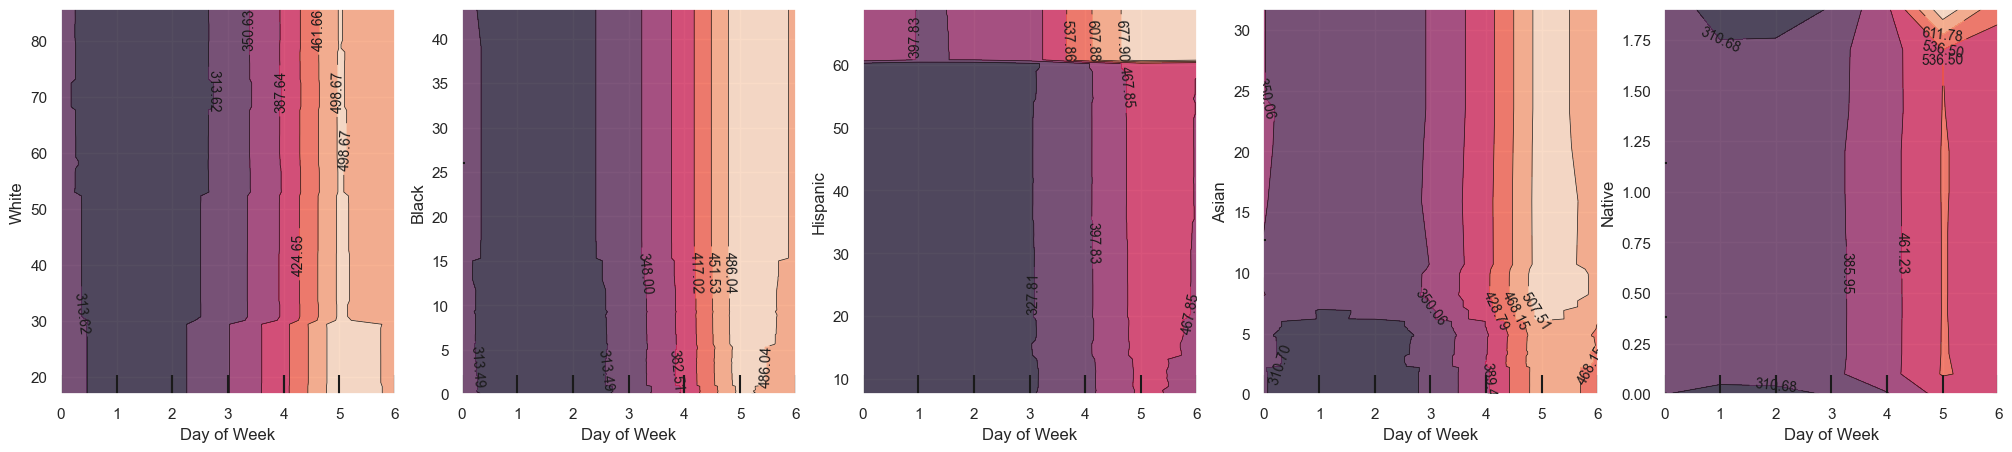

In [25]:
fig, ax = plt.subplots(1, 5, figsize=(25, 5))
features_PDP_2D = [('Day of Week', 'White')]
PartialDependenceDisplay.from_estimator(model, X, features_PDP_2D, ax=ax[0], kind='average')
ax[0].set_ylabel('Hispanic Ratio', size=14)
ax[0].set_xlabel('Hour (h)', size=14)
ax[0].grid()

features_PDP_2D = [('Day of Week', 'Black')]
PartialDependenceDisplay.from_estimator(model, X, features_PDP_2D, ax=ax[1], kind='average')
ax[1].set_ylabel('Hispanic Ratio', size=14)
ax[1].set_xlabel('Hour (h)', size=14)
ax[1].grid()

features_PDP_2D = [('Day of Week', 'Hispanic')]
PartialDependenceDisplay.from_estimator(model, X, features_PDP_2D, ax=ax[2], kind='average')
ax[2].set_ylabel('Hispanic Ratio', size=14)
ax[2].set_xlabel('Hour (h)', size=14)
ax[2].grid()

features_PDP_2D = [('Day of Week', 'Asian')]
PartialDependenceDisplay.from_estimator(model, X, features_PDP_2D, ax=ax[3], kind='average')
ax[3].set_ylabel('Hispanic Ratio', size=14)
ax[3].set_xlabel('Hour (h)', size=14)
ax[3].grid()

features_PDP_2D = [('Day of Week', 'Native')]
PartialDependenceDisplay.from_estimator(model, X, features_PDP_2D, ax=ax[4], kind='average')
ax[4].set_ylabel('Hispanic Ratio', size=14)
ax[4].set_xlabel('Hour (h)', size=14)
ax[4].grid()

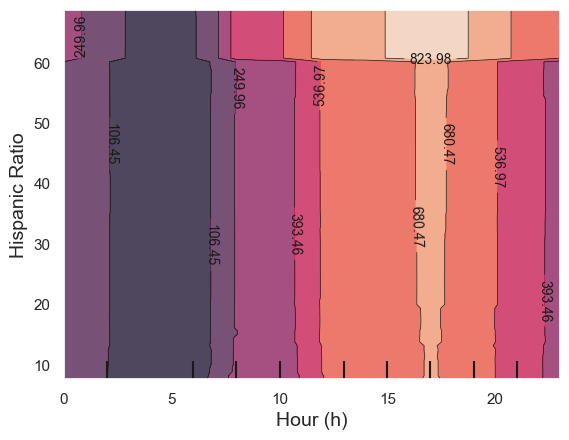

In [27]:
features_PDP_2D = [('Hour', 'Hispanic')]
PartialDependenceDisplay.from_estimator(model, X, features_PDP_2D, kind='average')
plt.ylabel('Hispanic Ratio', size=14)
plt.xlabel('Hour (h)', size=14)
plt.grid()


In [ ]:
import shap

In [ ]:
# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)
explainer = shap.Explainer(model)
shap_values = explainer(X, check_additivity=False)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


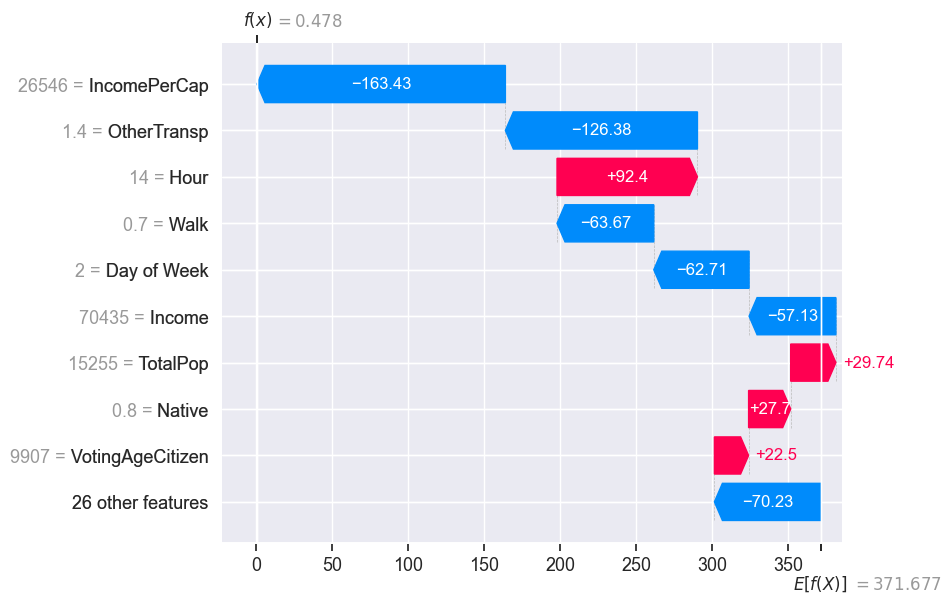

In [ ]:
# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[2])

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


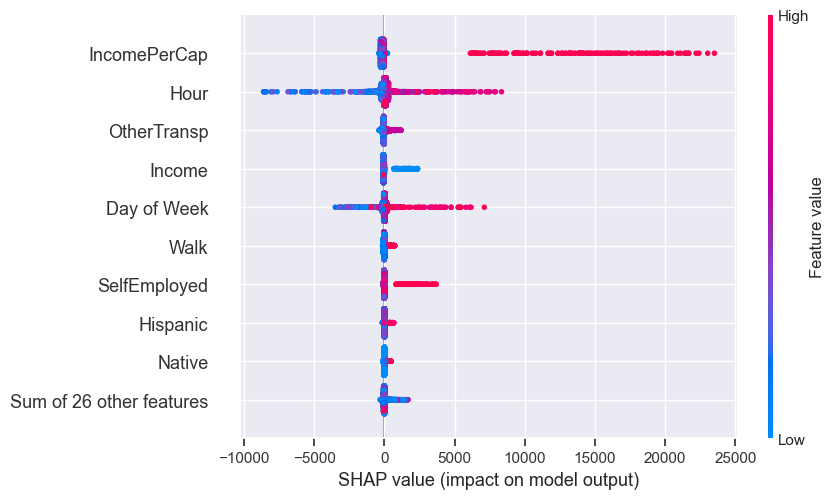

In [ ]:
# summarize the effects of all the features
shap.plots.beeswarm(shap_values)

In [ ]:
# # create a dependence scatter plot to show the effect of a single feature across the whole dataset
# shap.plots.scatter(shap_values[:,"Hispanic"], color=shap_values)

In [ ]:
# features_PDP = [('Hispanic')]
# PartialDependenceDisplay.from_estimator(model, X, features_PDP, kind='average')
# plt.ylabel('Hispanic Ratio', size=14)
# plt.xlabel('Hour (h)', size=14)
# plt.grid()

In [ ]:
# features_PDP = [('White')]
# PartialDependenceDisplay.from_estimator(model, X, features_PDP, kind='average')
# plt.ylabel('Hispanic Ratio', size=14)
# plt.xlabel('Hour (h)', size=14)
# plt.grid()